In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("Defenders.csv")
pd.set_option("display.max_columns", None)

df.head()
df.shape
df.info()
df.isna().mean().sort_values(ascending=False)
df.columns = df.columns.str.strip()
df.columns = (
    df.columns
    .str.strip()
    .str.replace(" ", "_")
)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 92 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Player                               503 non-null    object 
 1   Season                               503 non-null    object 
 2   Age                                  503 non-null    int64  
 3   Team                                 503 non-null    object 
 4   Goals                                503 non-null    float64
 5   Assist                               503 non-null    float64
 6   G+A                                  503 non-null    float64
 7   Non_penalty_goals                    503 non-null    float64
 8   Penalty_kicks-made                   503 non-null    float64
 9   Penalty_kicks_attempted              503 non-null    float64
 10  Expected_goals                       503 non-null    float64
 11  Non_penalty_xG                  

In [2]:
ID_COLS = ["Player", "Season", "Team", "Role"]
TARGET = "Tier_league"


In [3]:
df["Role"].value_counts()


Role
CB    245
RB    133
LB    125
Name: count, dtype: int64

In [4]:
defensive_central_roles = ["CB"]
lateral_offensive_roles = ["RB", "LB"]


In [5]:
df["role_group"] = np.where(
    df["Role"].isin(defensive_central_roles),
    "central_defensive",
    np.where(
        df["Role"].isin(lateral_offensive_roles),
        "lateral_offensive",
        "other"
    )
)


In [6]:
df["role_group"].value_counts()


role_group
lateral_offensive    258
central_defensive    245
Name: count, dtype: int64

In [7]:
na_cols = df.columns[df.isna().any()]
df[na_cols].isna().mean().sort_values(ascending=False)


Shots_onTarget                  0.113320
Goals_perShot_onTarget          0.071571
Succ_Takes_on%                  0.017893
Tkld_During_Take_On%            0.017893
Non_penalty_expGoals_perShot    0.007952
Shot_/90                        0.007952
Goals_per_shot                  0.007952
Passes_completed                0.007952
Shots_onTarget%                 0.007952
dtype: float64

In [8]:
ratio_cols = [
    "Goals_perShot_onTarget",
    "Succ_Takes_on%",
    "Tkld_During_Take_On%",
    "Non_penalty_expGoals_perShot",
    "Goals_per_shot",
    "Shots_onTarget%"
]


In [9]:
for col in ratio_cols:
    df[f"has_{col}"] = df[col].notna().astype(int)


In [10]:
df[[f"has_{c}" for c in ratio_cols]].mean().sort_values()


has_Goals_perShot_onTarget          0.928429
has_Succ_Takes_on%                  0.982107
has_Tkld_During_Take_On%            0.982107
has_Non_penalty_expGoals_perShot    0.992048
has_Goals_per_shot                  0.992048
has_Shots_onTarget%                 0.992048
dtype: float64

In [11]:
flag_cols = [f"has_{c}" for c in ratio_cols]
df = df.drop(columns=flag_cols)


In [12]:
df_central_def = df[df["role_group"] == "central_defensive"].copy()
df_lateral_def = df[df["role_group"] == "lateral_offensive"].copy()


In [13]:
df[TARGET].value_counts(normalize=True)


Tier_league
0    0.757455
1    0.242545
Name: proportion, dtype: float64

In [14]:
FEATURE_COLS = [
    c for c in df.columns
    if c not in ID_COLS + ["role_group", TARGET]
]


In [15]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
selector.fit(df[FEATURE_COLS])

low_var_features = [
    FEATURE_COLS[i]
    for i in range(len(FEATURE_COLS))
    if selector.variances_[i] < 0.01
]

low_var_features


['Goals',
 'Assist',
 'G+A',
 'Non_penalty_goals',
 'Penalty_kicks-made',
 'Penalty_kicks_attempted',
 'Expected_goals',
 'Non_penalty_xG',
 'Expected_assisted_goals',
 'xG+xAssisted_G',
 'Expected_assists',
 'Non_penalty_expGoals+assisted_goals',
 'Goals-Expected_goals',
 'Assists-expGoals_assisted',
 'Non_penalty_expGoals_perShot',
 'Red_cards',
 'Mistakes_leadto_shot']

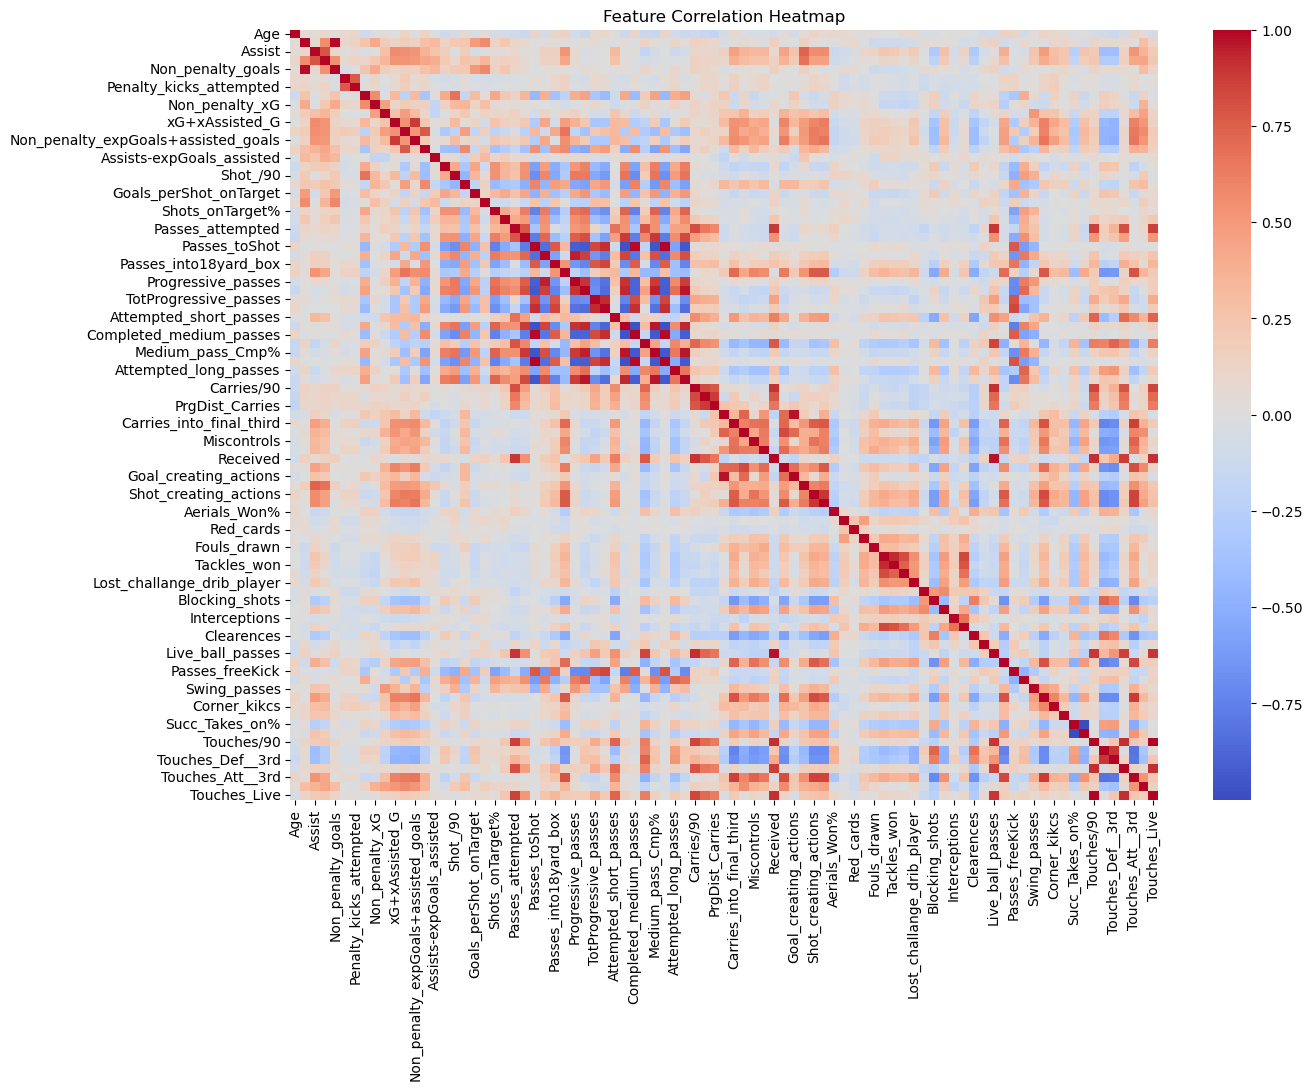

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[FEATURE_COLS].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


In [17]:
feature_variances = df[FEATURE_COLS].var().sort_values(ascending=False)

high_variance_features = feature_variances[feature_variances > 0.8]

high_variance_features


TotDist_completed_passes    163013.846140
TotProgressive_passes        81459.565477
Completed_short_passes       19117.852092
TotDist_Carries               2925.918648
Passes_toShot                 1524.282021
Completed_long_passes         1515.553301
PrgDist_Carries               1227.868233
Completed_medium_passes       1156.298676
Short_passes_Cmp%             1109.003241
Medium_pass_Cmp%               963.370627
Long_passes_Cmp%               618.509543
Succ_Takes_on%                 336.820026
Tkld_During_Take_On%           336.428159
Passes_completed               332.558052
Shots_onTarget%                308.763007
Passes_completition%           267.987518
Passes_attempted               151.181050
Aerials_Won%                   139.052390
Live_ball_passes               127.567390
Received                       118.483033
Touches/90                     112.854442
Touches_Live                   112.854204
Carries/90                      86.026745
Touches_Mid__3rd                61

In [18]:
df_central_def.to_csv("defenders_central.csv", index=False)
df_lateral_def.to_csv("defenders_lateral.csv", index=False)


In [19]:
FEATURE_COLS_CENTRAL = [
    c for c in df_central_def.columns
    if c not in ID_COLS + ["role_group", TARGET]
]

FEATURE_COLS_LATERAL = [
    c for c in df_lateral_def.columns
    if c not in ID_COLS + ["role_group", TARGET]
]


In [20]:
central_variance = (
    df_central_def[FEATURE_COLS_CENTRAL]
    .var()
    .sort_values(ascending=False)
)

central_variance.head(20)


TotDist_completed_passes    213184.203306
TotProgressive_passes       106023.238575
Completed_short_passes       25283.146793
TotDist_Carries               3787.062711
Completed_long_passes         1760.407460
Passes_toShot                 1759.431936
PrgDist_Carries               1637.894907
Short_passes_Cmp%             1288.605051
Completed_medium_passes       1131.700033
Medium_pass_Cmp%              1027.037025
Long_passes_Cmp%               758.645747
Passes_completed               435.429855
Tkld_During_Take_On%           392.280338
Succ_Takes_on%                 392.204529
Passes_completition%           343.926475
Shots_onTarget%                279.675614
Passes_attempted               189.505579
Live_ball_passes               166.349885
Received                       159.019215
Touches_Live                   149.863104
dtype: float64

In [21]:
central_variance.tail(20)


Goal_creating_actions                  0.006976
Carries_into18yard_box                 0.005767
G+A                                    0.005246
PassLive_lead_goal                     0.005049
Mistakes_leadto_shot                   0.004311
Non_penalty_expGoals_perShot           0.003896
Goals                                  0.003315
Non_penalty_goals                      0.003301
Goals-Expected_goals                   0.003295
Expected_assists                       0.002656
xG+xAssisted_G                         0.002615
Non_penalty_xG                         0.002508
Non_penalty_expGoals+assisted_goals    0.002451
Assist                                 0.002212
Expected_assisted_goals                0.001898
Expected_goals                         0.001664
Red_cards                              0.001535
Assists-expGoals_assisted              0.001433
Penalty_kicks_attempted                0.000041
Penalty_kicks-made                     0.000000
dtype: float64

In [22]:
lateral_variance = (
    df_lateral_def[FEATURE_COLS_LATERAL]
    .var()
    .sort_values(ascending=False)
)

lateral_variance.head(20)


TotDist_completed_passes    105469.919735
TotProgressive_passes        53252.024988
Completed_short_passes       13257.059351
TotDist_Carries               2116.948862
Passes_toShot                 1303.270029
Completed_long_passes         1288.801669
Completed_medium_passes       1181.648892
Short_passes_Cmp%              940.615276
PrgDist_Carries                837.451401
Medium_pass_Cmp%               828.189712
Long_passes_Cmp%               442.867785
Shots_onTarget%                336.065274
Passes_completed               235.695777
Passes_completition%           191.054903
Aerials_Won%                   143.400150
Succ_Takes_on%                 122.504966
Tkld_During_Take_On%           122.007656
Passes_attempted               111.164207
Touches/90                      76.542407
Touches_Live                    76.537884
dtype: float64

In [23]:
lateral_variance.tail(20)


Offsides                               0.014226
PassLive_lead_goal                     0.013526
Yellow_cards                           0.012417
G+A                                    0.011611
Assist                                 0.007507
Goals-Expected_goals                   0.007307
Expected_assists                       0.005273
Non_penalty_expGoals_perShot           0.005076
xG+xAssisted_G                         0.004965
Non_penalty_expGoals+assisted_goals    0.004280
Expected_assisted_goals                0.003574
Assists-expGoals_assisted              0.003462
Goals                                  0.002692
Non_penalty_goals                      0.002647
Mistakes_leadto_shot                   0.002495
Non_penalty_xG                         0.001890
Red_cards                              0.001480
Expected_goals                         0.000628
Penalty_kicks_attempted                0.000153
Penalty_kicks-made                     0.000115
dtype: float64

In [24]:
central_means = (
    df_central_def
    .groupby(TARGET)[FEATURE_COLS_CENTRAL]
    .mean()
    .T
)

central_means["diff"] = central_means[1] - central_means[0]
central_means.sort_values("diff", ascending=False).head(15)


Tier_league,0,1,diff
TotProgressive_passes,595.223243,769.530000,174.306757
TotDist_completed_passes,345.484865,441.883333,96.398468
TotDist_Carries,174.112432,230.888333,56.775901
Completed_short_passes,178.212432,221.431667,43.219234
PrgDist_Carries,99.662162,135.355000,35.692838
Passes_attempted,45.537297,59.853333,14.316036
Live_ball_passes,46.977838,60.683333,13.705495
Received,37.403243,50.576667,13.173423
Touches_Live,60.493514,73.083333,12.589820
Touches/90,60.494054,73.083333,12.589279


In [25]:
central_means.sort_values("diff").head(15)


Tier_league,0,1,diff
Shots_onTarget%,11.465027,9.571667,-1.893361
Age,23.843243,22.066667,-1.776577
Tkld_During_Take_On%,26.800562,25.322034,-1.478528
Clearences,3.960000,3.441667,-0.518333
Dead_ball_pass,3.131892,2.786667,-0.345225
Tackles_+Interc,3.240000,3.056667,-0.183333
Interceptions,1.586486,1.425000,-0.161486
Swing_passes,0.527568,0.376667,-0.150901
Crosses,0.421622,0.283333,-0.138288
Lost_challange_drib_player,0.627027,0.525000,-0.102027


In [26]:
lateral_means = (
    df_lateral_def
    .groupby(TARGET)[FEATURE_COLS_LATERAL]
    .mean()
    .T
)

lateral_means["diff"] = lateral_means[1] - lateral_means[0]
lateral_means.sort_values("diff", ascending=False).head(15)



Tier_league,0,1,diff
TotProgressive_passes,512.789796,604.187097,91.397301
TotDist_Carries,179.453061,205.183871,25.730810
Completed_short_passes,172.527041,186.424194,13.897153
PrgDist_Carries,102.112245,113.825806,11.713562
Live_ball_passes,42.051020,51.087097,9.036076
Received,35.110714,43.985484,8.874770
Passes_attempted,44.229592,52.037097,7.807505
Touches_Live,63.521939,71.320968,7.799029
Touches/90,63.523980,71.320968,7.796988
Carries/90,32.371429,39.170968,6.799539


In [27]:
lateral_means.sort_values("diff").head(15)

Tier_league,0,1,diff
TotDist_completed_passes,222.908163,220.109677,-2.798486
Long_passes_Cmp%,20.783163,19.495161,-1.288002
Dead_ball_pass,10.150510,9.153226,-0.997284
Carries_10yards_forward,3.388776,2.641935,-0.746840
Medium_pass_Cmp%,39.271939,38.664516,-0.607423
Touches_Def__3rd,18.829592,18.222581,-0.607011
Succ_Takes_on%,55.206667,54.696774,-0.509892
Shots_onTarget%,9.328351,8.956452,-0.371899
Age,23.887755,23.548387,-0.339368
Touches_Def_Pen,3.044388,2.800000,-0.244388


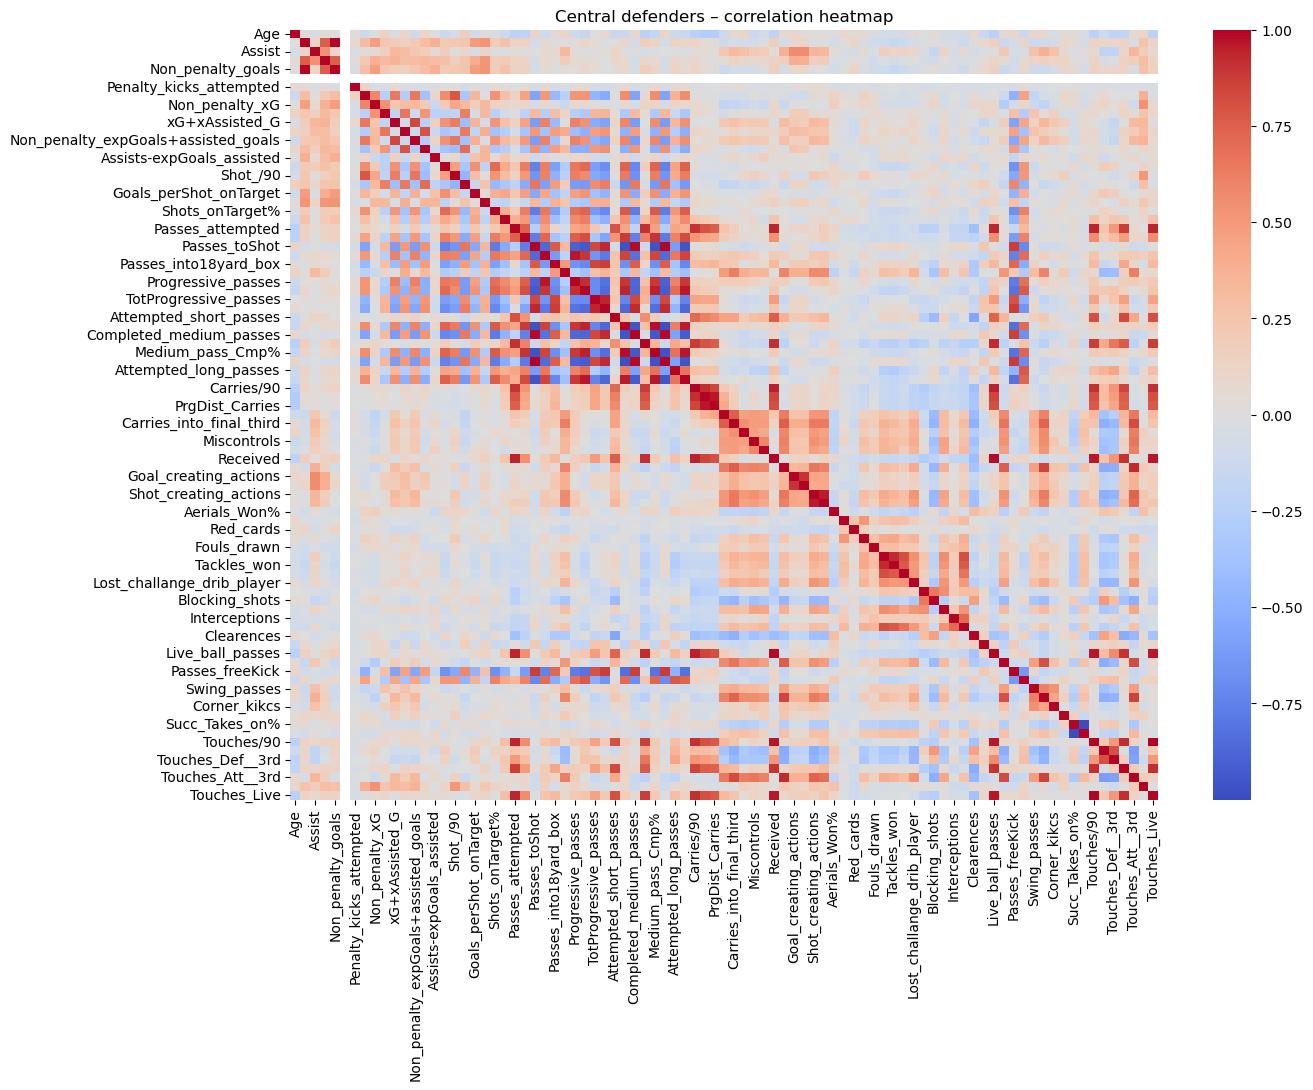

In [28]:
corr_central = df_central_def[FEATURE_COLS_CENTRAL].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_central, cmap="coolwarm", center=0)
plt.title("Central defenders – correlation heatmap")
plt.show()


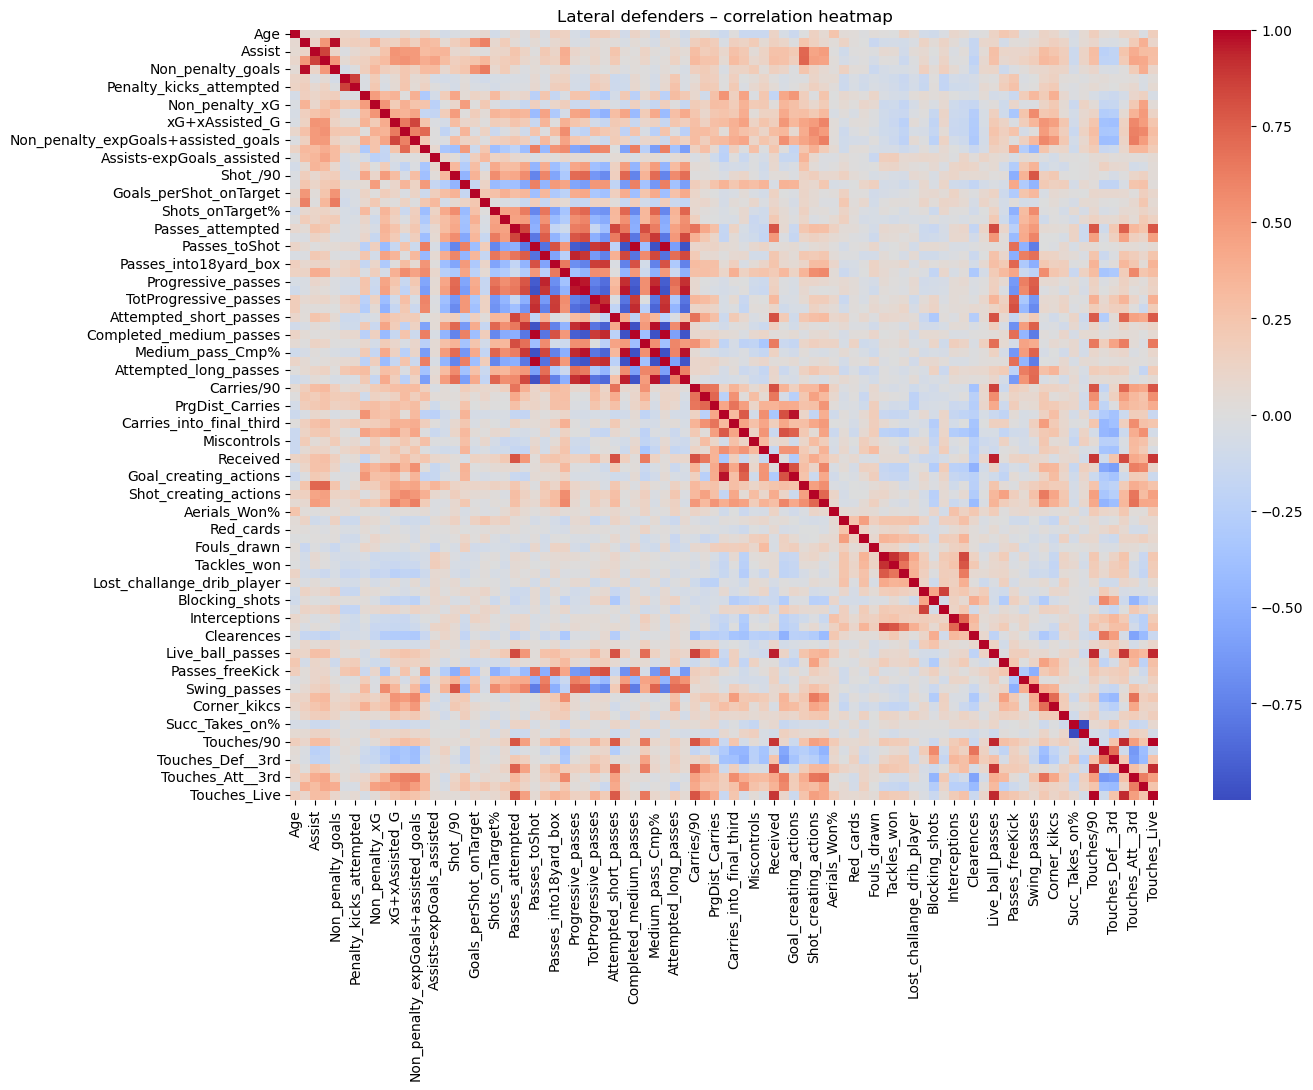

In [29]:
corr_lateral = df_lateral_def[FEATURE_COLS_LATERAL].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_lateral, cmap="coolwarm", center=0)
plt.title("Lateral defenders – correlation heatmap")
plt.show()


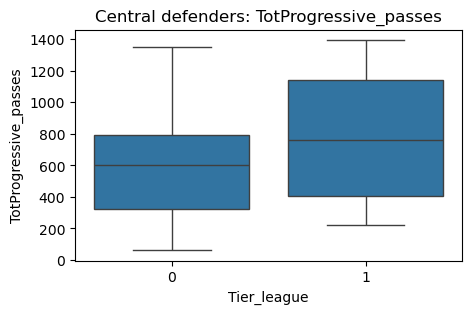

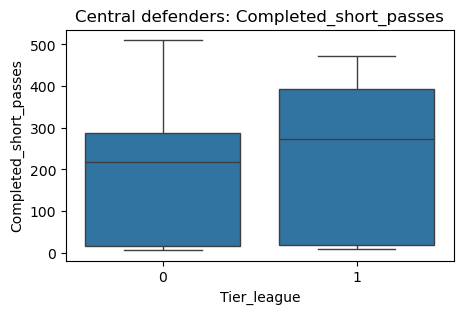

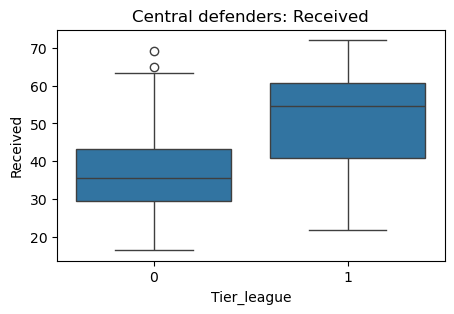

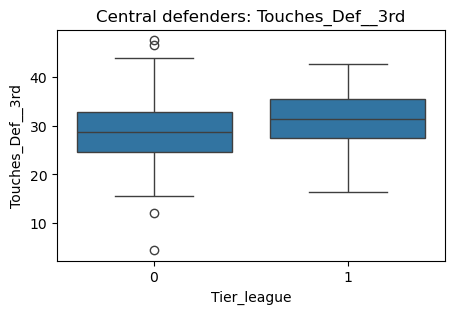

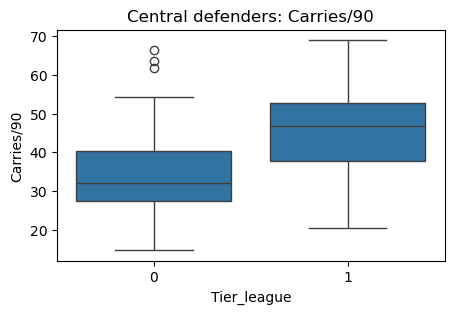

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

key_cb_features = [
    "TotProgressive_passes",
    "Completed_short_passes",
    "Received",
    "Touches_Def__3rd",
    "Carries/90"
]

for col in key_cb_features:
    plt.figure(figsize=(5,3))
    sns.boxplot(
        x=TARGET,
        y=col,
        data=df_central_def
    )
    plt.title(f"Central defenders: {col}")
    plt.show()


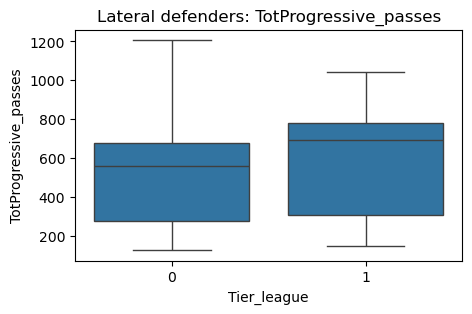

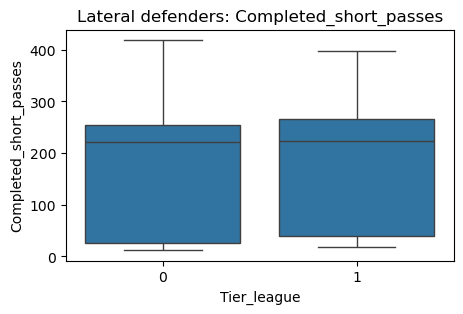

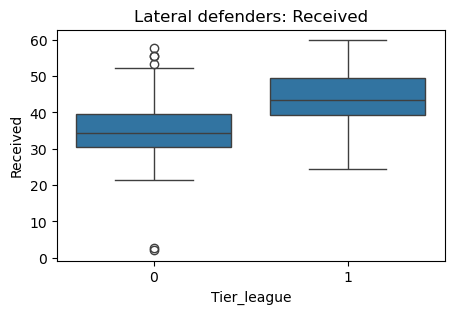

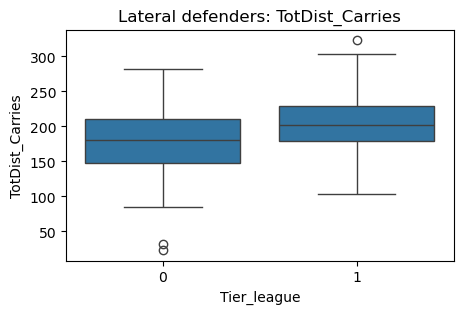

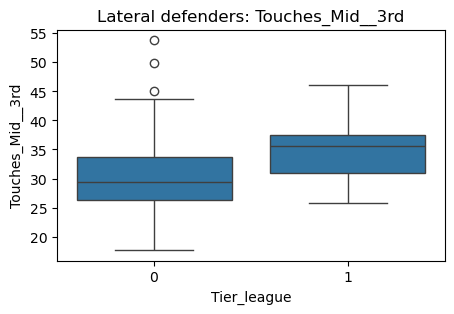

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

key_ld_features = [
    "TotProgressive_passes",
    "Completed_short_passes",
    "Received",
    "TotDist_Carries",
    "Touches_Mid__3rd"
]

for col in key_ld_features:
    plt.figure(figsize=(5,3))
    sns.boxplot(
        x=TARGET,
        y=col,
        data=df_lateral_def
    )
    plt.title(f"Lateral defenders: {col}")
    plt.show()


In [45]:
import numpy as np
import pandas as pd

def get_highly_correlated_pairs(df, feature_cols, threshold=0.8):
    corr = df[feature_cols].corr().abs()
    
    upper = corr.where(
        np.triu(np.ones(corr.shape), k=1).astype(bool)
    )
    
    high_corr = (
        upper
        .stack()
        .reset_index()
        .rename(columns={"level_0": "feature_1",
                         "level_1": "feature_2",
                         0: "corr"})
        .query("corr >= @threshold")
        .sort_values("corr", ascending=False)
    )
    
    return high_corr


In [49]:
high_corr_central = get_highly_correlated_pairs(
    df_central_def,
    FEATURE_COLS_CENTRAL,
    threshold=0.8
)

high_corr_central.head(30)


,feature_1,feature_2,corr
3639,Touches/90,Touches_Live,1.000000
3619,Succ_Takes_on%,Tkld_During_Take_On%,1.000000
1714,Passes_toShot,Completed_long_passes,0.998308
87,Goals,Non_penalty_goals,0.993833
2935,Received,Live_ball_passes,0.989014
2279,Completed_medium_passes,Completed_long_passes,0.988581
1711,Passes_toShot,Completed_medium_passes,0.987438
2226,Short_passes_Cmp%,Medium_pass_Cmp%,0.984114
2227,Short_passes_Cmp%,Completed_long_passes,0.977304
1710,Passes_toShot,Short_passes_Cmp%,0.973043


In [51]:
high_corr_lateral = get_highly_correlated_pairs(
    df_lateral_def,
    FEATURE_COLS_LATERAL,
    threshold=0.8
)

high_corr_lateral.head(30)


,feature_1,feature_2,corr
3725,Touches/90,Touches_Live,0.999998
3705,Succ_Takes_on%,Tkld_During_Take_On%,0.999603
1800,Passes_toShot,Completed_long_passes,0.997604
1797,Passes_toShot,Completed_medium_passes,0.995014
2365,Completed_medium_passes,Completed_long_passes,0.992930
2312,Short_passes_Cmp%,Medium_pass_Cmp%,0.982159
88,Goals,Non_penalty_goals,0.978426
2801,Carries_10yards_forward,Goal_creating_actions,0.975845
1799,Passes_toShot,Medium_pass_Cmp%,0.975355
2364,Completed_medium_passes,Medium_pass_Cmp%,0.975267


In [55]:
DROP_FEATURES = [
    "Touches/90",
    "Touches_Live",
    "Tkld_During_Take_On%",
    "Passes_toShot",
    "Completed_medium_passes",
    "Completed_long_passes",
    "Carries/90",
    "TotDist_Carries",
    "Goals",
    "Non_penalty_goals",
    "Expected_goals",
    "Non_penalty_xG",
    "xG+xAssisted_G",
    "G+A",
    "Penalty_kicks_attempted",
    "Penalty_kicks-made",
    "Live_ball_passes"
]


In [57]:
df_central_def = df_central_def.drop(columns=[c for c in DROP_FEATURES if c in df_central_def.columns])
df_lateral_def = df_lateral_def.drop(columns=[c for c in DROP_FEATURES if c in df_lateral_def.columns])


In [67]:
FEATURE_COLS_CENTRAL = [
    c for c in df_central_def.columns
    if c not in ID_COLS + ["role_group", TARGET]
]

FEATURE_COLS_LATERAL = [
    c for c in df_lateral_def.columns
    if c not in ID_COLS + ["role_group", TARGET]
]


In [69]:
high_corr_central = get_highly_correlated_pairs(
    df_central_def,
    FEATURE_COLS_CENTRAL,
    threshold=0.8
)

high_corr_lateral = get_highly_correlated_pairs(
    df_lateral_def,
    FEATURE_COLS_LATERAL,
    threshold=0.8
)


In [73]:
high_corr_central.head(20)


,feature_1,feature_2,corr
1381,Short_passes_Cmp%,Medium_pass_Cmp%,0.984114
1470,Medium_pass_Cmp%,Long_passes_Cmp%,0.966949
1197,TotDist_completed_passes,Long_passes_Cmp%,0.963226
986,Passes_into_last3rd,Progressive_passes,0.962851
1950,Shot_creating_actions,PassLive_lead_shot_attempt,0.955873
1383,Short_passes_Cmp%,Long_passes_Cmp%,0.953740
1195,TotDist_completed_passes,Medium_pass_Cmp%,0.947485
1239,TotProgressive_passes,Completed_short_passes,0.942242
895,Passes_attempted,Received,0.940250
1193,TotDist_completed_passes,Short_passes_Cmp%,0.939112


In [75]:
high_corr_lateral.head(20)


,feature_1,feature_2,corr
1381,Short_passes_Cmp%,Medium_pass_Cmp%,0.982159
1641,Carries_10yards_forward,Goal_creating_actions,0.975845
1195,TotDist_completed_passes,Medium_pass_Cmp%,0.972509
1470,Medium_pass_Cmp%,Long_passes_Cmp%,0.970015
1140,Progressive_passes,TotDist_completed_passes,0.963139
1193,TotDist_completed_passes,Short_passes_Cmp%,0.961384
1197,TotDist_completed_passes,Long_passes_Cmp%,0.960685
1383,Short_passes_Cmp%,Long_passes_Cmp%,0.946360
986,Passes_into_last3rd,Progressive_passes,0.938435
1146,Progressive_passes,Medium_pass_Cmp%,0.922951


In [77]:
MORE_DROP_FEATURES = [
    "Short_passes_Cmp%",
    "Medium_pass_Cmp%",
    "Long_passes_Cmp%",
    "Progressive_passes",
    "Passes_into_last3rd",
    "TotDist_completed_passes",
    "Tackles_on_players"
]


In [79]:
df_central_def = df_central_def.drop(
    columns=[c for c in MORE_DROP_FEATURES if c in df_central_def.columns]
)

df_lateral_def = df_lateral_def.drop(
    columns=[c for c in MORE_DROP_FEATURES if c in df_lateral_def.columns]
)


In [81]:
FEATURE_COLS_CENTRAL = [
    c for c in df_central_def.columns
    if c not in ID_COLS + ["role_group", TARGET]
]

FEATURE_COLS_LATERAL = [
    c for c in df_lateral_def.columns
    if c not in ID_COLS + ["role_group", TARGET]
]

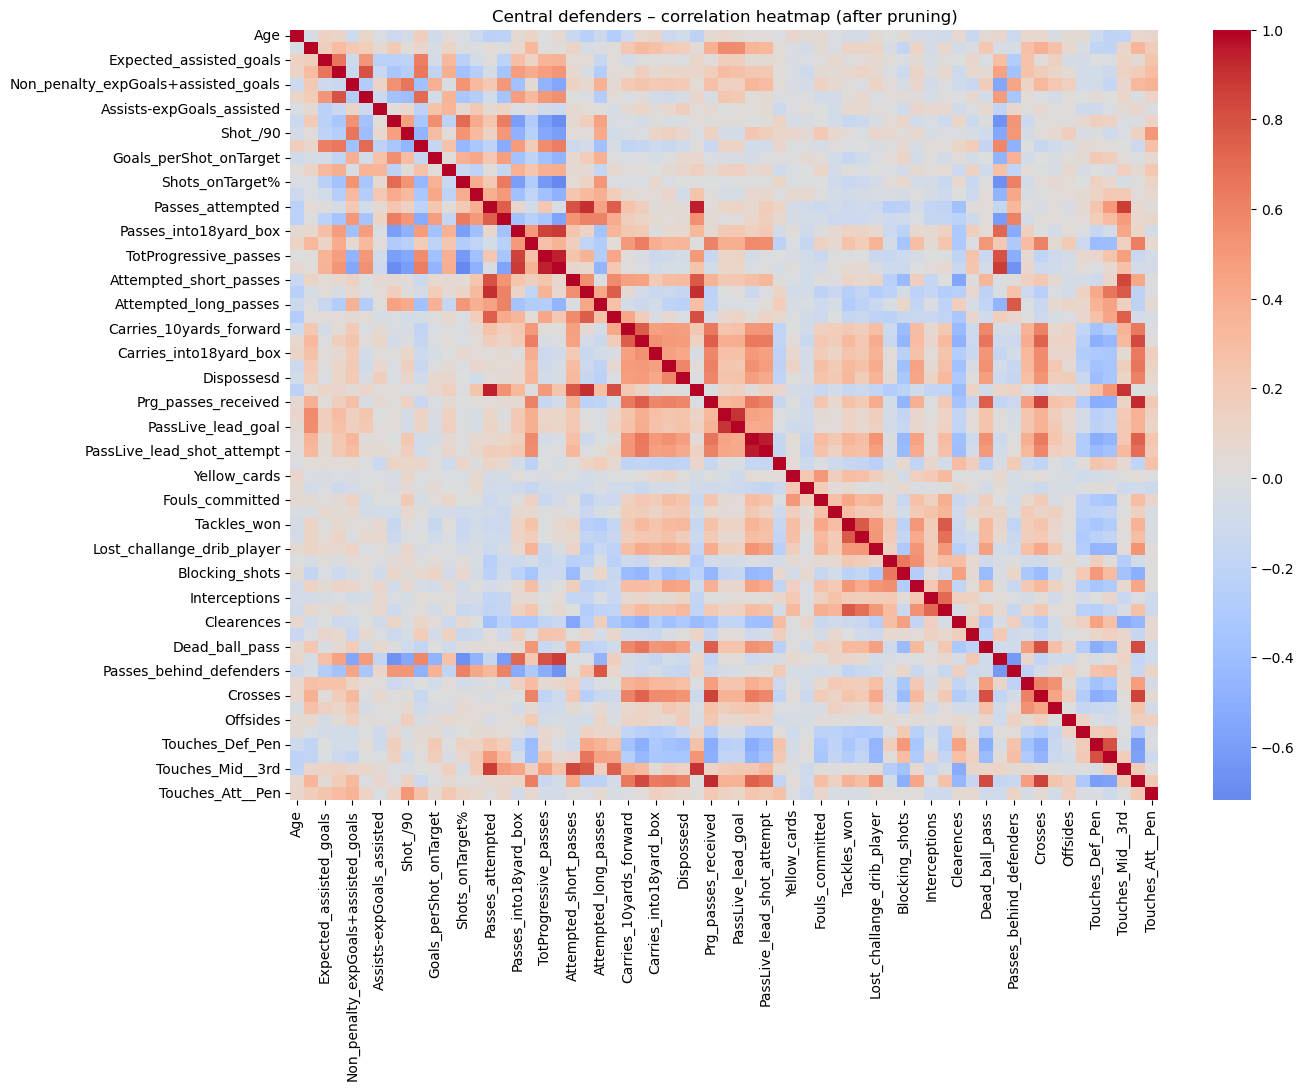

In [83]:
corr_central = df_central_def[FEATURE_COLS_CENTRAL].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_central, cmap="coolwarm", center=0)
plt.title("Central defenders – correlation heatmap (after pruning)")
plt.show()


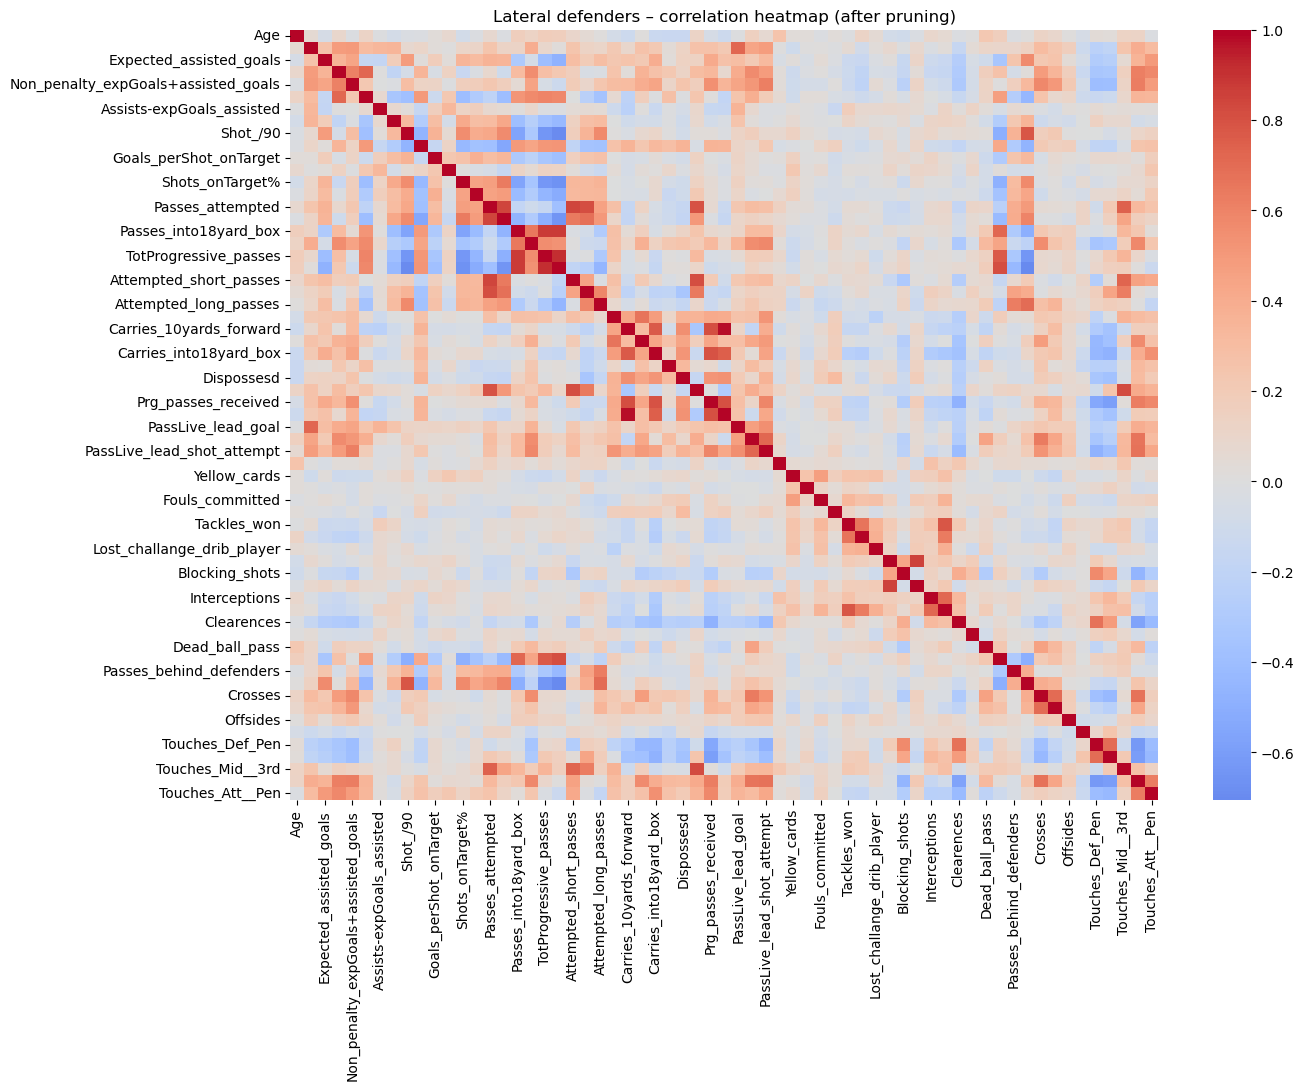

In [85]:
corr_lateral = df_lateral_def[FEATURE_COLS_LATERAL].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_lateral, cmap="coolwarm", center=0)
plt.title("Lateral defenders – correlation heatmap (after pruning)")
plt.show()


In [87]:
high_corr_central = get_highly_correlated_pairs(
    df_central_def,
    FEATURE_COLS_CENTRAL,
    threshold=0.8
)

high_corr_lateral = get_highly_correlated_pairs(
    df_lateral_def,
    FEATURE_COLS_LATERAL,
    threshold=0.8
)


In [89]:
high_corr_central.head(20)

,feature_1,feature_2,corr
1518,Shot_creating_actions,PassLive_lead_shot_attempt,0.955873
963,TotProgressive_passes,Completed_short_passes,0.942242
791,Passes_attempted,Received,0.940250
1455,Prg_passes_received,Touches_Att__3rd,0.924603
1099,Attempted_medium_passes,Received,0.914426
783,Passes_attempted,Attempted_medium_passes,0.907228
1422,Received,Touches_Mid__3rd,0.904635
1457,Goal_creating_actions,PassLive_lead_goal,0.902240
874,Passes_into18yard_box,Completed_short_passes,0.874980
822,Passes_attempted,Touches_Mid__3rd,0.870949


In [91]:
high_corr_lateral.head(20)

,feature_1,feature_2,corr
1218,Carries_10yards_forward,Goal_creating_actions,0.975845
963,TotProgressive_passes,Completed_short_passes,0.914860
874,Passes_into18yard_box,Completed_short_passes,0.878859
873,Passes_into18yard_box,TotProgressive_passes,0.873999
1764,Blocking_ball,Blocking_pass,0.853313
777,Passes_attempted,Passes_completition%,0.845847
782,Passes_attempted,Attempted_short_passes,0.840849
1422,Received,Touches_Mid__3rd,0.825200
783,Passes_attempted,Attempted_medium_passes,0.817110
1217,Carries_10yards_forward,Prg_passes_received,0.808934


In [93]:
DROP_SHARED = [
    "Completed_short_passes",
    "Passes_into18yard_box",
    "Attempted_medium_passes",
    "Attempted_short_passes",
    "PassLive_lead_shot_attempt",
    "PassLive_lead_goal"
]
DROP_CENTRAL = [
    "Prg_passes_received",
    "Carries_into_final_third",
    "Received",
    "Touches_Def_Pen"
]
DROP_LATERAL = [
    "Prg_passes_received",
    "Goal_creating_actions",
    "Touches_Mid_3rd",
    "Blocking_ball"
]


In [95]:
df_central_def = df_central_def.drop(
    columns=[c for c in DROP_SHARED + DROP_CENTRAL if c in df_central_def.columns]
)

df_lateral_def = df_lateral_def.drop(
    columns=[c for c in DROP_SHARED + DROP_LATERAL if c in df_lateral_def.columns]
)


In [97]:
FEATURE_COLS_CENTRAL = [
    c for c in df_central_def.columns
    if c not in ID_COLS + ["role_group", TARGET]
]

FEATURE_COLS_LATERAL = [
    c for c in df_lateral_def.columns
    if c not in ID_COLS + ["role_group", TARGET]
]

In [99]:
high_corr_central = get_highly_correlated_pairs(
    df_central_def,
    FEATURE_COLS_CENTRAL,
    threshold=0.8
)

high_corr_lateral = get_highly_correlated_pairs(
    df_lateral_def,
    FEATURE_COLS_LATERAL,
    threshold=0.8
)


In [101]:
high_corr_central.head(20)

,feature_1,feature_2,corr
672,Passes_attempted,Touches_Mid__3rd,0.870949
1355,Crosses,Touches_Att__3rd,0.855745
1321,Dead_ball_pass,Touches_Att__3rd,0.823972
1315,Dead_ball_pass,Crosses,0.810436
772,TotProgressive_passes,Passes_freeKick,0.804347
154,Expected_assists,Goals-Expected_goals,0.800819


In [103]:
high_corr_lateral.head(20)

,feature_1,feature_2,corr
651,Passes_attempted,Passes_completition%,0.845847
1050,Received,Touches_Mid__3rd,0.825200


In [117]:
df_central_def.describe().T


,count,mean,std,min,25%,50%,75%,max
Age,245.0,23.408163,2.859542,18.0,21.00,23.00,26.000,28.00
Assist,245.0,0.019184,0.047037,0.0,0.00,0.00,0.000,0.40
Expected_assisted_goals,245.0,0.025306,0.043566,0.0,0.00,0.00,0.100,0.10
Expected_assists,245.0,0.040000,0.051534,0.0,0.00,0.00,0.100,0.20
Non_penalty_expGoals+assisted_goals,245.0,0.035102,0.049511,0.0,0.00,0.00,0.100,0.20
Goals-Expected_goals,245.0,0.035918,0.057400,-0.1,0.00,0.00,0.100,0.20
Assists-expGoals_assisted,245.0,-0.001224,0.037854,-0.1,0.00,0.00,0.000,0.20
Non_penalty_expGoals_perShot,243.0,0.045967,0.062418,-0.1,0.00,0.00,0.100,0.27
Shot_/90,242.0,0.280702,0.316521,0.0,0.09,0.15,0.400,2.80
Goals_per_shot,243.0,0.277531,0.240594,0.0,0.08,0.20,0.400,1.10


In [119]:
df_lateral_def.describe().T


,count,mean,std,min,25%,50%,75%,max
Age,258.0,23.806202,2.693348,18.0,22.0000,24.00,26.0000,28.00
Assist,258.0,0.080233,0.086640,0.0,0.0000,0.10,0.1000,0.50
Expected_assisted_goals,258.0,0.044961,0.059781,0.0,0.0000,0.00,0.1000,0.30
Expected_assists,258.0,0.113178,0.072616,0.0,0.1000,0.10,0.1000,0.40
Non_penalty_expGoals+assisted_goals,258.0,0.100775,0.065418,0.0,0.1000,0.10,0.1000,0.40
Goals-Expected_goals,258.0,0.084496,0.085483,-0.2,0.0000,0.10,0.1000,0.40
Assists-expGoals_assisted,258.0,-0.001163,0.058836,-0.2,0.0000,0.00,0.0000,0.30
Non_penalty_expGoals_perShot,256.0,0.017109,0.071243,-0.2,0.0000,0.00,0.0525,0.26
Shot_/90,257.0,0.188677,0.241956,0.0,0.0400,0.08,0.2000,1.30
Goals_per_shot,256.0,0.414570,0.387823,0.0,0.0975,0.30,0.6000,2.20


In [121]:
DROP_CENTRAL_FINAL = [
    "Assist",
    "Expected_assisted_goals",
    "Expected_assists",
    "Non_penalty_expGoals+assisted_goals",
    "Goals-Expected_goals",
    "Assists-expGoals_assisted",
    "Non_penalty_expGoals_perShot",
    "Goals_per_shot",
    "Goals_perShot_onTarget",
    "Shots_onTarget",
    "Shots_onTarget%",
    "Shot/90",
    "Corner_kicks",
    "Offsides",
    "Red_cards",
    "Mistakes_leadto_shot"
]
DROP_LATERAL_FINAL = [
    "Red_cards",
    "Mistakes_leadto_shot",
    "Corner_kicks",
    "Offsides",
    "Non_penalty_expGoals_perShot"
]


In [123]:
df_central_def = df_central_def.drop(
    columns=[c for c in DROP_CENTRAL_FINAL if c in df_central_def.columns]
)
df_lateral_def = df_lateral_def.drop(
    columns=[c for c in DROP_LATERAL_FINAL if c in df_lateral_def.columns]
)

In [125]:
FEATURE_COLS_CENTRAL = [
    c for c in df_central_def.columns
    if c not in ID_COLS + ["role_group", TARGET]
]

FEATURE_COLS_LATERAL = [
    c for c in df_lateral_def.columns
    if c not in ID_COLS + ["role_group", TARGET]
]


In [127]:
len(FEATURE_COLS_CENTRAL), len(FEATURE_COLS_LATERAL)


(39, 50)

In [129]:
df_central_def[FEATURE_COLS_CENTRAL] = df_central_def[FEATURE_COLS_CENTRAL].fillna(0)
df_lateral_def[FEATURE_COLS_LATERAL] = df_lateral_def[FEATURE_COLS_LATERAL].fillna(0)


In [131]:
df_central_final = df_central_def.copy()
df_lateral_final = df_lateral_def.copy()


In [139]:
df_central_final.shape

(245, 45)

In [141]:
df_lateral_final.shape

(258, 56)

In [143]:
df_central_final.to_csv("central_defenders_final.csv", index=False)
df_lateral_final.to_csv("lateral_defenders_final.csv", index=False)


In [147]:
print(f"Central defenders – number of features: {len(FEATURE_COLS_CENTRAL)}\n")

for c in sorted(FEATURE_COLS_CENTRAL):
    print(c)


Central defenders – number of features: 39

Aerials_Won%
Age
Attempted_long_passes
Blocking_ball
Blocking_pass
Blocking_shots
Carries_10yards_forward
Carries_into18yard_box
Clearences
Corner_kikcs
Crosses
Crosses_into18yard_box
Dead_ball_pass
Dispossesd
Fouls_committed
Fouls_drawn
Goal_creating_actions
Interceptions
Lost_challange_drib_player
Miscontrols
Passes_attempted
Passes_behind_defenders
Passes_completed
Passes_completition%
Passes_freeKick
PrgDist_Carries
Shot_/90
Shot_creating_actions
Succ_Takes_on%
Swing_passes
Tackles_+Interc
Tackles_on_dribblers
Tackles_won
TotProgressive_passes
Touches_Att__3rd
Touches_Att__Pen
Touches_Def__3rd
Touches_Mid__3rd
Yellow_cards


In [151]:
DROP_CENTRAL_TIDY = [
    "Touches_Att__Pen"
]
df_central_final = df_central_final.drop(
    columns=[c for c in DROP_CENTRAL_TIDY if c in df_central_final.columns]
)
FEATURE_COLS_CENTRAL = [
    c for c in df_central_final.columns
    if c not in ID_COLS + ["role_group", TARGET]
]


In [149]:
print(f"Lateral defenders – number of features: {len(FEATURE_COLS_LATERAL)}\n")

for c in sorted(FEATURE_COLS_LATERAL):
    print(c)


Lateral defenders – number of features: 50

Aerials_Won%
Age
Assist
Assists-expGoals_assisted
Attempted_long_passes
Blocking_pass
Blocking_shots
Carries_10yards_forward
Carries_into18yard_box
Carries_into_final_third
Clearences
Corner_kikcs
Crosses
Crosses_into18yard_box
Dead_ball_pass
Dispossesd
Expected_assisted_goals
Expected_assists
Fouls_committed
Fouls_drawn
Goals-Expected_goals
Goals_perShot_onTarget
Goals_per_shot
Interceptions
Lost_challange_drib_player
Miscontrols
Non_penalty_expGoals+assisted_goals
Passes_attempted
Passes_behind_defenders
Passes_completed
Passes_completition%
Passes_freeKick
PrgDist_Carries
Received
Shot_/90
Shot_creating_actions
Shots_onTarget
Shots_onTarget%
Succ_Takes_on%
Swing_passes
Tackles_+Interc
Tackles_on_dribblers
Tackles_won
TotProgressive_passes
Touches_Att__3rd
Touches_Att__Pen
Touches_Def_Pen
Touches_Def__3rd
Touches_Mid__3rd
Yellow_cards


In [167]:
DROP_LATERAL_TIDY = [
    "Passes_completed",

    "Shots_onTarget",
    "Shots_onTarget%",
    "Goals_per_shot",
    "Goals_perShot_onTarget",
    "Goals-Expected_goals",

    "Assist",
    "Expected_assisted_goals",
    "Assists-expGoals_assisted",
    "Non_penalty_expGoals+assisted_goals",

    "Carries_10yards_forward",
    "Carries_into18yard_box"
]
df_lateral_final = df_lateral_final.drop(
    columns=[c for c in DROP_LATERAL_TIDY if c in df_lateral_final.columns]
)
FEATURE_COLS_LATERAL = [
    c for c in df_lateral_final.columns
    if c not in ID_COLS + ["role_group", TARGET]
]


In [169]:
df_central_final.to_csv("central_defenders_final.csv", index=False)
df_lateral_final.to_csv("lateral_defenders_final.csv", index=False)


In [171]:
pd.Series(FEATURE_COLS_CENTRAL).to_csv(
    "central_defenders_features.csv", index=False, header=["feature"]
)

pd.Series(FEATURE_COLS_LATERAL).to_csv(
    "lateral_defenders_features.csv", index=False, header=["feature"]
)


In [173]:
print("Central features:", len(FEATURE_COLS_CENTRAL))
print("Lateral features:", len(FEATURE_COLS_LATERAL))


Central features: 38
Lateral features: 38


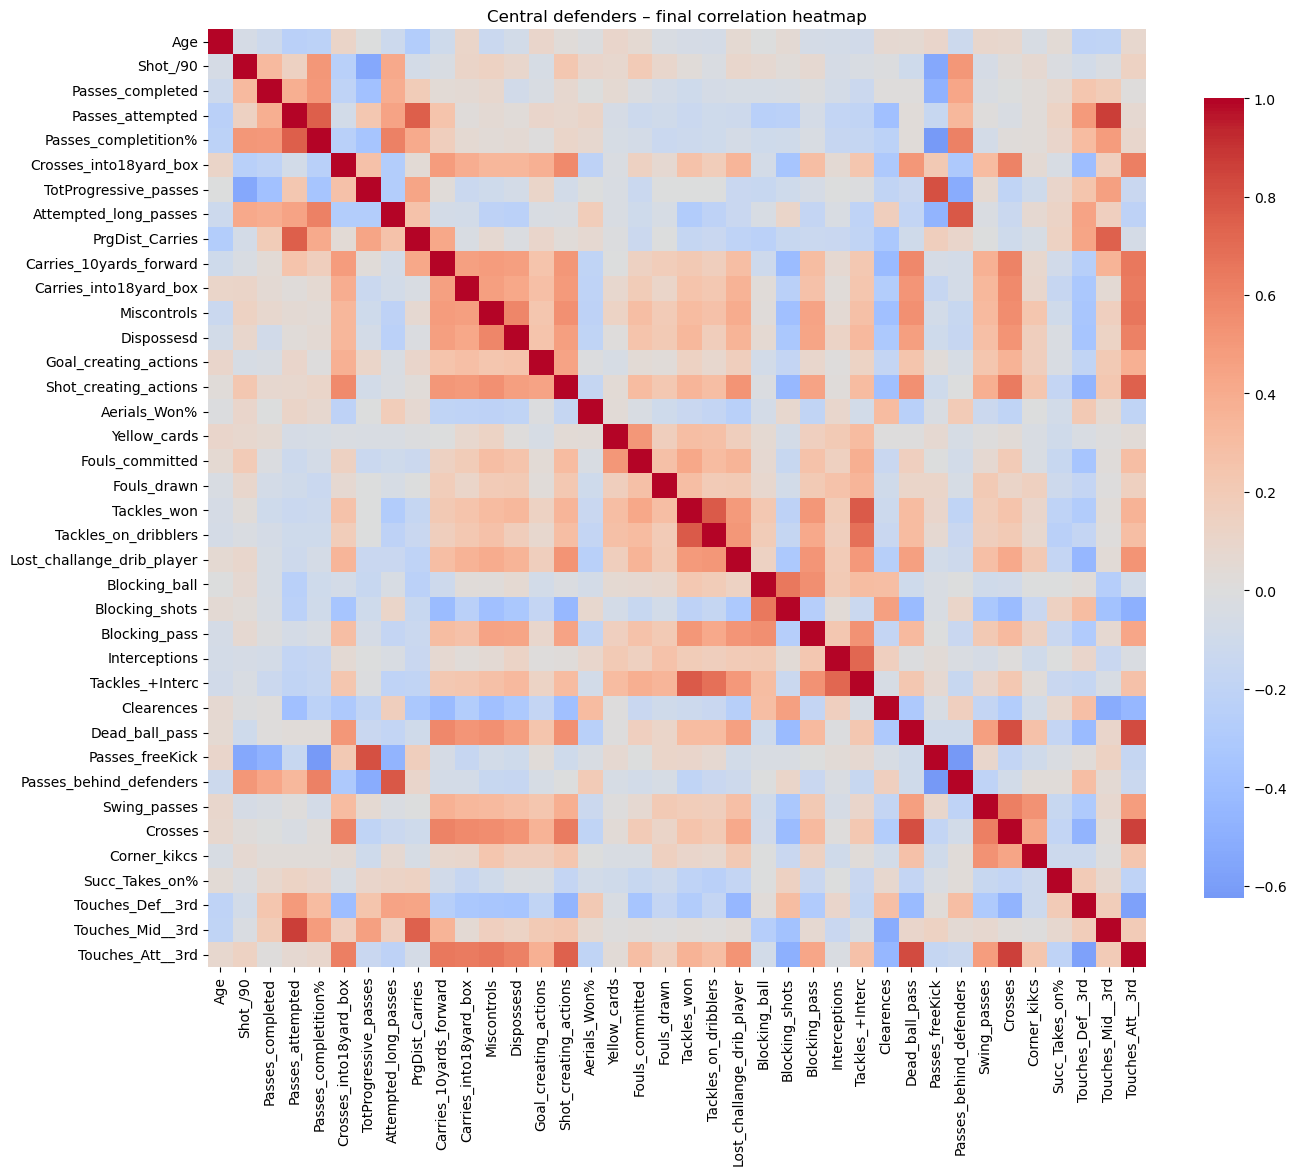

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_central = df_central_def[FEATURE_COLS_CENTRAL].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_central,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Central defenders – final correlation heatmap")
plt.tight_layout()
plt.show()


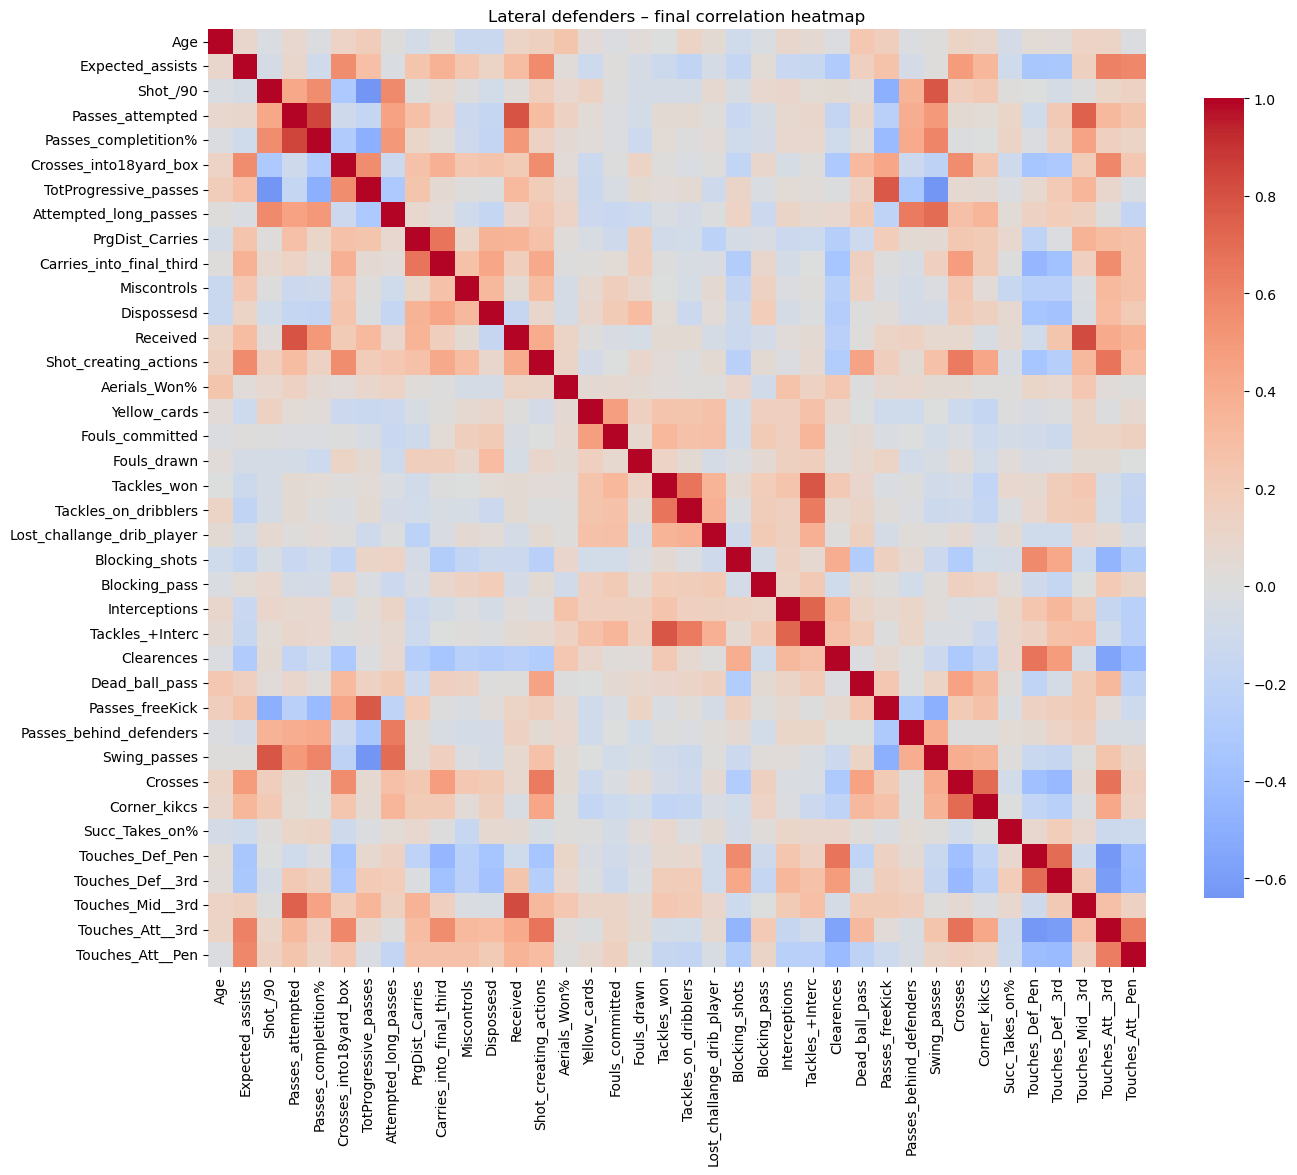

In [177]:
corr_lateral = df_lateral_def[FEATURE_COLS_LATERAL].corr()

plt.figure(figsize=(14, 12))

sns.heatmap(
    corr_lateral,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Lateral defenders – final correlation heatmap")
plt.tight_layout()
plt.show()


In [179]:
def get_high_corr_pairs(df, feature_cols, threshold=0.85):
    corr = df[feature_cols].corr().abs()
    upper = corr.where(
        np.triu(np.ones(corr.shape), k=1).astype(bool)
    )

    high_corr = (
        upper.stack()
        .reset_index()
        .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "corr"})
        .query("corr >= @threshold")
        .sort_values("corr", ascending=False)
    )
    return high_corr


In [185]:
high_corr_central = get_high_corr_pairs(
    df_central_def,
    FEATURE_COLS_CENTRAL,
    threshold=0.80
)

high_corr_central



,feature_1,feature_2,corr
140,Passes_attempted,Touches_Mid__3rd,0.870949
692,Crosses,Touches_Att__3rd,0.855745
666,Dead_ball_pass,Touches_Att__3rd,0.823972
661,Dead_ball_pass,Crosses,0.810436
229,TotProgressive_passes,Passes_freeKick,0.804347


In [187]:
high_corr_lateral = get_high_corr_pairs(
    df_lateral_def,
    FEATURE_COLS_LATERAL,
    threshold=0.80
)

high_corr_lateral


,feature_1,feature_2,corr
108,Passes_attempted,Passes_completition%,0.845847
400,Received,Touches_Mid__3rd,0.825200


### Baseline models

In [15]:

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    accuracy_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


from xgboost import XGBClassifier


RANDOM_STATE = 42


In [16]:
df_central = pd.read_csv("central_defenders_final.csv")
df_lateral = pd.read_csv("lateral_defenders_final.csv")


In [17]:
ID_COLS = ["Player", "Season", "Team", "Role"]

In [18]:
df_central.shape, df_lateral.shape


((245, 42), (258, 43))

In [19]:
set(ID_COLS).issubset(df_central.columns), set(ID_COLS).issubset(df_lateral.columns)


(True, True)

In [20]:
TARGET = "Tier_league"


In [21]:
df_central[TARGET].value_counts(normalize=True), df_lateral[TARGET].value_counts(normalize=True)


(Tier_league
 0    0.755102
 1    0.244898
 Name: proportion, dtype: float64,
 Tier_league
 0    0.75969
 1    0.24031
 Name: proportion, dtype: float64)

In [22]:
FEATURE_COLS_CENTRAL = [
    c for c in df_central.columns
    if c not in ID_COLS + [TARGET]
]

FEATURE_COLS_LATERAL = [
    c for c in df_lateral.columns
    if c not in ID_COLS + [TARGET]
]

print("Central features:", len(FEATURE_COLS_CENTRAL))
print("Lateral features:", len(FEATURE_COLS_LATERAL))


Central features: 37
Lateral features: 38


In [23]:
X_central = df_central[FEATURE_COLS_CENTRAL]
y_central = df_central[TARGET]

X_lateral = df_lateral[FEATURE_COLS_LATERAL]
y_lateral = df_lateral[TARGET]


In [24]:
X_central.shape, X_lateral.shape


((245, 37), (258, 38))

In [25]:
def run_cv_model(model, X, y, n_splits=5):
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=RANDOM_STATE
    )

    aucs, f1s, accs = [], [], []

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)
        probs = model.predict_proba(X_val)[:, 1]
        preds = (probs >= 0.5).astype(int)

        aucs.append(roc_auc_score(y_val, probs))
        f1s.append(f1_score(y_val, preds))
        accs.append(accuracy_score(y_val, preds))

    return {
        "roc_auc": np.mean(aucs),
        "f1": np.mean(f1s),
        "accuracy": np.mean(accs)
    }


In [26]:
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])


In [27]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE
)


In [28]:
mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        alpha=1e-4,
        max_iter=500,
        early_stopping=True,
        random_state=RANDOM_STATE
    ))
])


In [29]:
results = []

results.append(("Logistic", "Central", run_cv_model(log_reg, X_central, y_central)))
results.append(("Logistic", "Lateral", run_cv_model(log_reg, X_lateral, y_lateral)))

results.append(("XGBoost", "Central", run_cv_model(xgb, X_central, y_central)))
results.append(("XGBoost", "Lateral", run_cv_model(xgb, X_lateral, y_lateral)))

results.append(("MLP", "Central", run_cv_model(mlp, X_central, y_central)))
results.append(("MLP", "Lateral", run_cv_model(mlp, X_lateral, y_lateral)))


In [30]:
results_df = pd.DataFrame([
    {
        "Model": m,
        "Role": r,
        "ROC_AUC": s["roc_auc"],
        "F1": s["f1"],
        "Accuracy": s["accuracy"]
    }
    for m, r, s in results
])

results_df


,Model,Role,ROC_AUC,F1,Accuracy
0,Logistic,Central,0.792793,0.617303,0.783673
1,Logistic,Lateral,0.834301,0.636765,0.794495
2,XGBoost,Central,0.814414,0.512229,0.800000
3,XGBoost,Lateral,0.821012,0.585355,0.821644
4,MLP,Central,0.572072,0.042105,0.710204
5,MLP,Lateral,0.683056,0.330868,0.779035


### Ranking models

In [32]:
def dcg_at_k(y_true, y_score, k=20):
    order = np.argsort(y_score)[::-1][:k]
    y_true_k = y_true.iloc[order].values

    gains = (2 ** y_true_k - 1)
    discounts = np.log2(np.arange(2, k + 2))

    return np.sum(gains / discounts)


def ndcg_at_k(y_true, y_score, k=20):
    ideal_dcg = dcg_at_k(y_true, y_true, k)
    if ideal_dcg == 0:
        return 0.0
    return dcg_at_k(y_true, y_score, k) / ideal_dcg


In [33]:
def hit_at_k(y_true, y_score, k=20):
    order = np.argsort(y_score)[::-1][:k]
    return y_true.iloc[order].mean()


In [34]:
def run_cv_ranking(model, X, y, k=20, n_splits=5):
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=RANDOM_STATE
    )

    hits, ndcgs = [], []

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)
        probs = model.predict_proba(X_val)[:, 1]

        hits.append(hit_at_k(y_val, probs, k))
        ndcgs.append(ndcg_at_k(y_val, probs, k))

    return {
        "Hit@20": np.mean(hits),
        "NDCG@20": np.mean(ndcgs)
    }


In [35]:
ranking_results = []

ranking_results.append(
    ("Logistic", "Central", run_cv_ranking(log_reg, X_central, y_central))
)
ranking_results.append(
    ("Logistic", "Lateral", run_cv_ranking(log_reg, X_lateral, y_lateral))
)

ranking_results.append(
    ("XGBoost", "Central", run_cv_ranking(xgb, X_central, y_central))
)
ranking_results.append(
    ("XGBoost", "Lateral", run_cv_ranking(xgb, X_lateral, y_lateral))
)

ranking_results.append(
    ("MLP", "Central", run_cv_ranking(mlp, X_central, y_central))
)
ranking_results.append(
    ("MLP", "Lateral", run_cv_ranking(mlp, X_lateral, y_lateral))
)


In [36]:
ranking_df = pd.DataFrame([
    {
        "Model": m,
        "Role": r,
        "Hit@20": s["Hit@20"],
        "NDCG@20": s["NDCG@20"]
    }
    for m, r, s in ranking_results
])

ranking_df


,Model,Role,Hit@20,NDCG@20
0,Logistic,Central,0.45,0.714636
1,Logistic,Lateral,0.47,0.788809
2,XGBoost,Central,0.47,0.774931
3,XGBoost,Lateral,0.45,0.755163
4,MLP,Central,0.28,0.377534
5,MLP,Lateral,0.36,0.592110


### Tuning Models ###

In [132]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



from xgboost import XGBClassifier


In [133]:
RANDOM_STATE = 42
N_SPLITS = 5
K_RANK = 20


In [134]:
def eval_fold_metrics(y_true, probs, k=20):
    preds = (probs >= 0.5).astype(int)

    out = {}
    out["roc_auc"] = roc_auc_score(y_true, probs)
    out["f1"] = f1_score(y_true, preds, zero_division=0)
    out["accuracy"] = accuracy_score(y_true, preds)

    out["Hit@20"] = hit_at_k(y_true, probs, k)
    out["NDCG@20"] = ndcg_at_k(y_true, probs, k)
    return out


In [135]:
def run_cv_all_metrics(model, X, y, k=20, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    scores = {"roc_auc": [], "f1": [], "accuracy": [], "Hit@20": [], "NDCG@20": []}

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)
        probs = model.predict_proba(X_val)[:, 1]

        fold = eval_fold_metrics(y_val, probs, k=k)
        for key in scores:
            scores[key].append(fold[key])

    return {k: float(np.mean(v)) for k, v in scores.items()}


In [136]:
def build_logistic(params):
    C = params["C"]
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            penalty="l2",
            C=params["C"],
            class_weight=params["class_weight"],
            solver="lbfgs",
            max_iter=10000,
            random_state=RANDOM_STATE
        ))
    ])

def build_xgb(params):
    return XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        learning_rate=params["learning_rate"],
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        min_child_weight=params["min_child_weight"],
        reg_lambda=params["reg_lambda"]
    )

def build_mlp(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(
            hidden_layer_sizes=params["hidden_layer_sizes"],
            alpha=params["alpha"],
            learning_rate_init=params["learning_rate_init"],
            activation=params["activation"],
            max_iter=2000,
            early_stopping=True,
            n_iter_no_change=20,
            random_state=RANDOM_STATE
        ))
    ])


In [137]:

LOG_GRID = {
    "C": [0.01, 0.1, 1.0, 3.0, 10.0, 30.0, 100.0],
    "class_weight": [None, "balanced"]
}


XGB_GRID = [
    {
        "n_estimators": n,
        "max_depth": d,
        "learning_rate": lr,
        "subsample": ss,
        "colsample_bytree": cs,
        "min_child_weight": mcw,
        "reg_lambda": rl
    }
    for n in [200, 500]
    for d in [3, 4, 5]
    for lr in [0.03, 0.05, 0.1]
    for ss in [0.7, 0.9]
    for cs in [0.7, 0.9]
    for mcw in [1, 5]
    for rl in [1.0, 5.0]
]

MLP_GRID = [
    {
        "hidden_layer_sizes": h,
        "alpha": a,
        "learning_rate_init": lr,
        "activation": act
    }
    for h in [(32,), (64,), (64, 32)]
    for a in [1e-5, 1e-4, 1e-3]
    for lr in [1e-3, 3e-4]
    for act in ["relu", "tanh"]
]


In [138]:
def tune_model(model_name, role_name, build_fn, param_grid, X, y, k=20):
    best = None
    rows = []

    if isinstance(param_grid, dict):
        grid_iter = ParameterGrid(param_grid)
    else:
        grid_iter = param_grid  # assume list of dicts

    for params in grid_iter:
        model = build_fn(params)
        scores = run_cv_all_metrics(model, X, y, k=k, n_splits=N_SPLITS)

        row = {
            "Model": model_name,
            "Role": role_name,
            **params,
            "ROC_AUC": scores["roc_auc"],
            "F1": scores["f1"],
            "Accuracy": scores["accuracy"],
            "Hit@20": scores["Hit@20"],
            "NDCG@20": scores["NDCG@20"],
        }
        rows.append(row)

        if best is None or row["NDCG@20"] > best["NDCG@20"]:
            best = row

    results = pd.DataFrame(rows).sort_values("NDCG@20", ascending=False).reset_index(drop=True)
    return best, results


In [139]:
ID_COLS = ["Player", "Season", "Team", "Role"]
TARGET = "Tier_league"

X_central = df_central[FEATURE_COLS_CENTRAL].copy()
y_central = df_central[TARGET].astype(int).copy()

X_lateral = df_lateral[FEATURE_COLS_LATERAL].copy()
y_lateral = df_lateral[TARGET].astype(int).copy()


In [140]:
all_best = []
all_runs = []

# Logistic
best, runs = tune_model("Logistic", "Central", build_logistic, LOG_GRID, X_central, y_central, k=K_RANK)
all_best.append(best); all_runs.append(runs)

best, runs = tune_model("Logistic", "Lateral", build_logistic, LOG_GRID, X_lateral, y_lateral, k=K_RANK)
all_best.append(best); all_runs.append(runs)

# XGBoost
best, runs = tune_model("XGBoost", "Central", build_xgb, XGB_GRID, X_central, y_central, k=K_RANK)
all_best.append(best); all_runs.append(runs)

best, runs = tune_model("XGBoost", "Lateral", build_xgb, XGB_GRID, X_lateral, y_lateral, k=K_RANK)
all_best.append(best); all_runs.append(runs)

# MLP
best, runs = tune_model("MLP", "Central", build_mlp, MLP_GRID, X_central, y_central, k=K_RANK)
all_best.append(best); all_runs.append(runs)

best, runs = tune_model("MLP", "Lateral", build_mlp, MLP_GRID, X_lateral, y_lateral, k=K_RANK)
all_best.append(best); all_runs.append(runs)

best_params_df = pd.DataFrame(all_best)


In [141]:
results_df = best_params_df[["Model", "Role", "ROC_AUC", "F1", "Accuracy"]].copy()
results_df = results_df.sort_values(["Role", "ROC_AUC"], ascending=[True, False]).reset_index(drop=True)
results_df


,Model,Role,ROC_AUC,F1,Accuracy
0,XGBoost,Central,0.837387,0.491472,0.800000
1,Logistic,Central,0.832883,0.584726,0.738776
2,MLP,Central,0.800450,0.567584,0.746939
3,Logistic,Lateral,0.876689,0.612361,0.844947
4,MLP,Lateral,0.859505,0.632193,0.786576
5,XGBoost,Lateral,0.836138,0.597143,0.821644


In [142]:
ranking_df = best_params_df[["Model", "Role", "Hit@20", "NDCG@20"]].copy()
ranking_df = ranking_df.sort_values(["Role", "NDCG@20"], ascending=[True, False]).reset_index(drop=True)
ranking_df


,Model,Role,Hit@20,NDCG@20
0,XGBoost,Central,0.50,0.820637
1,Logistic,Central,0.48,0.764035
2,MLP,Central,0.45,0.762305
3,Logistic,Lateral,0.51,0.830268
4,MLP,Lateral,0.50,0.816867
5,XGBoost,Lateral,0.49,0.808475


In [143]:
param_cols = [c for c in best_params_df.columns if c not in ["ROC_AUC", "F1", "Accuracy", "Hit@20", "NDCG@20"]]
best_params_df[param_cols + ["ROC_AUC", "F1", "Accuracy", "Hit@20", "NDCG@20"]]


,Model,Role,C,class_weight,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,min_child_weight,reg_lambda,hidden_layer_sizes,alpha,learning_rate_init,activation,ROC_AUC,F1,Accuracy,Hit@20,NDCG@20
0,Logistic,Central,0.01,balanced,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.832883,0.584726,0.738776,0.48,0.764035
1,Logistic,Lateral,0.10,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.876689,0.612361,0.844947,0.51,0.830268
2,XGBoost,Central,NaN,NaN,200.0,5.0,0.1,0.7,0.7,1.0,5.0,NaN,NaN,NaN,NaN,0.837387,0.491472,0.800000,0.50,0.820637
3,XGBoost,Lateral,NaN,NaN,500.0,5.0,0.1,0.7,0.7,1.0,5.0,NaN,NaN,NaN,NaN,0.836138,0.597143,0.821644,0.49,0.808475
4,MLP,Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(64, 32)",0.00001,0.001,tanh,0.800450,0.567584,0.746939,0.45,0.762305
5,MLP,Lateral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(64, 32)",0.00001,0.001,tanh,0.859505,0.632193,0.786576,0.50,0.816867


### Best Models and Scoring prob ###

In [157]:

BEST_XGB_CENTRAL = {
    "n_estimators": 200,
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "min_child_weight": 1,
    "reg_lambda": 5.0
}

BEST_LOG_LATERAL = {
    "C": 0.10,
    "class_weight": None  
}


BEST_MLP_CENTRAL = {
    "hidden_layer_sizes": (64, 32),
    "alpha": 1e-5,
    "learning_rate_init": 1e-3,
    "activation": "tanh"
}

BEST_MLP_LATERAL = {
    "hidden_layer_sizes": (64, 32),
    "alpha": 1e-5,
    "learning_rate_init": 1e-3,
    "activation": "tanh"
}


In [159]:
# =========================
# Model builders
# =========================

def build_logistic(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            C=params["C"],
            class_weight=params["class_weight"],
            solver="lbfgs",
            max_iter=10000,
            random_state=RANDOM_STATE
        ))
    ])

def build_mlp(params):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(
            hidden_layer_sizes=params["hidden_layer_sizes"],
            alpha=params["alpha"],
            learning_rate_init=params["learning_rate_init"],
            activation=params["activation"],
            max_iter=2000,
            early_stopping=True,
            n_iter_no_change=20,
            random_state=RANDOM_STATE
        ))
    ])

def build_xgb(params):
    return XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        learning_rate=params["learning_rate"],
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        min_child_weight=params["min_child_weight"],
        reg_lambda=params["reg_lambda"]
    )

def fit_and_score(df, X, y, model, model_name):
    model.fit(X, y)
    probs = model.predict_proba(X)[:, 1]

    out = df[ID_COLS + [TARGET]].copy()
    out[f"p_upward_{model_name}"] = probs
    out[f"rank_{model_name}"] = out[f"p_upward_{model_name}"].rank(method="first", ascending=False).astype(int)
    out[f"percentile_{model_name}"] = out[f"p_upward_{model_name}"].rank(pct=True)

    out = out.sort_values(f"p_upward_{model_name}", ascending=False).reset_index(drop=True)
    return out, model

# =========================
# Retrain on full data
# =========================


central_best_model = build_xgb(BEST_XGB_CENTRAL)
lateral_best_model = build_logistic(BEST_LOG_LATERAL)

central_scout_best, central_best_fitted = fit_and_score(
    df_central, X_central, y_central, central_best_model, model_name="best"
)

lateral_scout_best, lateral_best_fitted = fit_and_score(
    df_lateral, X_lateral, y_lateral, lateral_best_model, model_name="best"
)


central_mlp_model = build_mlp(BEST_MLP_CENTRAL)
lateral_mlp_model = build_mlp(BEST_MLP_LATERAL)

central_scout_mlp, central_mlp_fitted = fit_and_score(
    df_central, X_central, y_central, central_mlp_model, model_name="mlp"
)

lateral_scout_mlp, lateral_mlp_fitted = fit_and_score(
    df_lateral, X_lateral, y_lateral, lateral_mlp_model, model_name="mlp"
)

print("Done: retrained and scored best models plus MLP.")


Done: retrained and scored best models plus MLP.


In [163]:
# =========================
# Create final scouting tables
# =========================

def make_shortlists(df_ranked, model_tag="best", top_k_list=(20, 50)):
    out = {}
    for k in top_k_list:
        out[k] = df_ranked.head(k).copy()
    return out

# Full ranked tables (best)
central_ranked_best = central_scout_best.copy()
lateral_ranked_best = lateral_scout_best.copy()

# Shortlists (best)
central_shortlists_best = make_shortlists(central_ranked_best, model_tag="best", top_k_list=(20, 50))
lateral_shortlists_best = make_shortlists(lateral_ranked_best, model_tag="best", top_k_list=(20, 50))

# Merge best and mlp probabilities side by side (same dataset so same rows)
central_ranked_combined = central_scout_best.merge(
    central_scout_mlp[ID_COLS + ["p_upward_mlp", "rank_mlp", "percentile_mlp"]],
    on=ID_COLS,
    how="left"
)

lateral_ranked_combined = lateral_scout_best.merge(
    lateral_scout_mlp[ID_COLS + ["p_upward_mlp", "rank_mlp", "percentile_mlp"]],
    on=ID_COLS,
    how="left"
)

# Save CSVs
central_ranked_best.to_csv("scouting_central_ranked_best.csv", index=False)
lateral_ranked_best.to_csv("scouting_lateral_ranked_best.csv", index=False)

central_ranked_combined.to_csv("scouting_central_ranked_best_plus_mlp.csv", index=False)
lateral_ranked_combined.to_csv("scouting_lateral_ranked_best_plus_mlp.csv", index=False)

central_shortlists_best[20].to_csv("scouting_central_top20_best.csv", index=False)
central_shortlists_best[50].to_csv("scouting_central_top50_best.csv", index=False)

lateral_shortlists_best[20].to_csv("scouting_lateral_top20_best.csv", index=False)
lateral_shortlists_best[50].to_csv("scouting_lateral_top50_best.csv", index=False)

print("Saved scouting tables:")
print("scouting_central_ranked_best.csv")
print("scouting_lateral_ranked_best.csv")
print("scouting_central_ranked_best_plus_mlp.csv")
print("scouting_lateral_ranked_best_plus_mlp.csv")
print("scouting_central_top20_best.csv, scouting_central_top50_best.csv")
print("scouting_lateral_top20_best.csv, scouting_lateral_top50_best.csv")


central_ranked_best.head(15)


Saved scouting tables:
scouting_central_ranked_best.csv
scouting_lateral_ranked_best.csv
scouting_central_ranked_best_plus_mlp.csv
scouting_lateral_ranked_best_plus_mlp.csv
scouting_central_top20_best.csv, scouting_central_top50_best.csv
scouting_lateral_top20_best.csv, scouting_lateral_top50_best.csv


,Player,Season,Team,Role,Tier_league,p_upward_best,rank_best,percentile_best
0,Jean-Clair Todibo,2021-2022,Nice,CB,1,0.981336,1,1.000000
1,William Saliba,2021-2022,Marseille,CB,1,0.975740,2,0.995918
2,Presnel Kimpembe,2020-2021,Paris S-G,CB,1,0.974876,3,0.991837
3,Nayef Aguerd,2020-2021,Rennes,CB,1,0.972529,4,0.987755
4,Presnel Kimpembe,2019-2020,Paris S-G,CB,1,0.971304,5,0.983673
5,Marquinhos,2018-2019,Paris S-G,CB,1,0.969097,6,0.979592
6,Benoît Badiashile,2021-2022,Monaco,CB,1,0.964506,7,0.975510
7,Thilo Kehrer,2020-2021,Paris S-G,CB,1,0.963509,8,0.971429
8,Thilo Kehrer,2018-2019,Paris S-G,CB,1,0.963054,9,0.967347
9,Sven Botman,2020-2021,Lille,CB,1,0.961795,10,0.963265


### SHAP feature importance ###

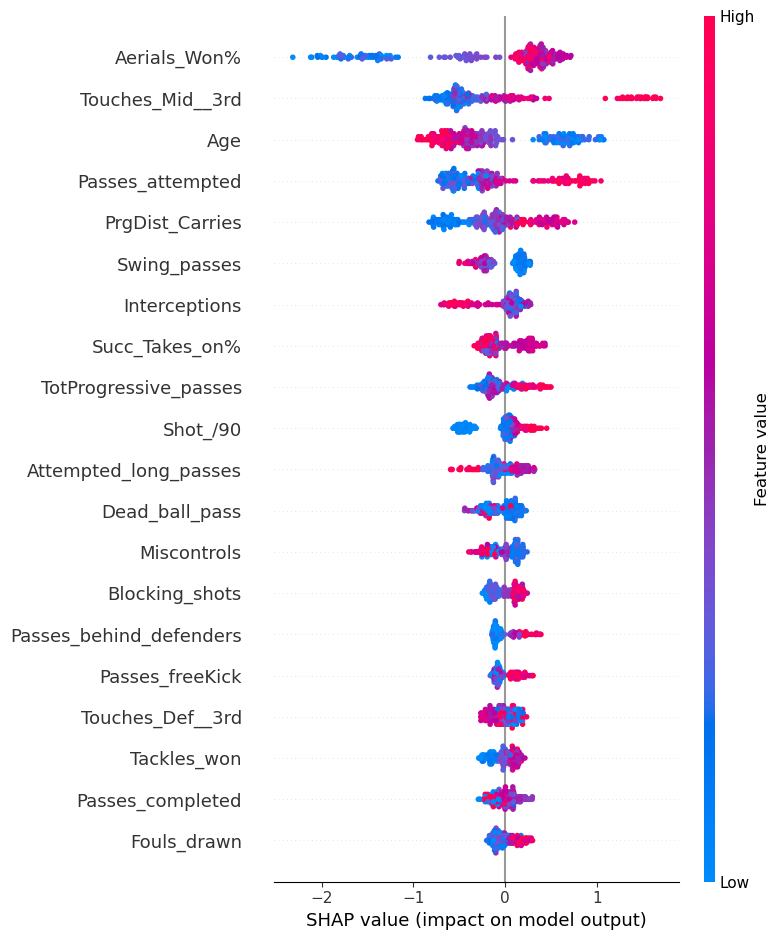

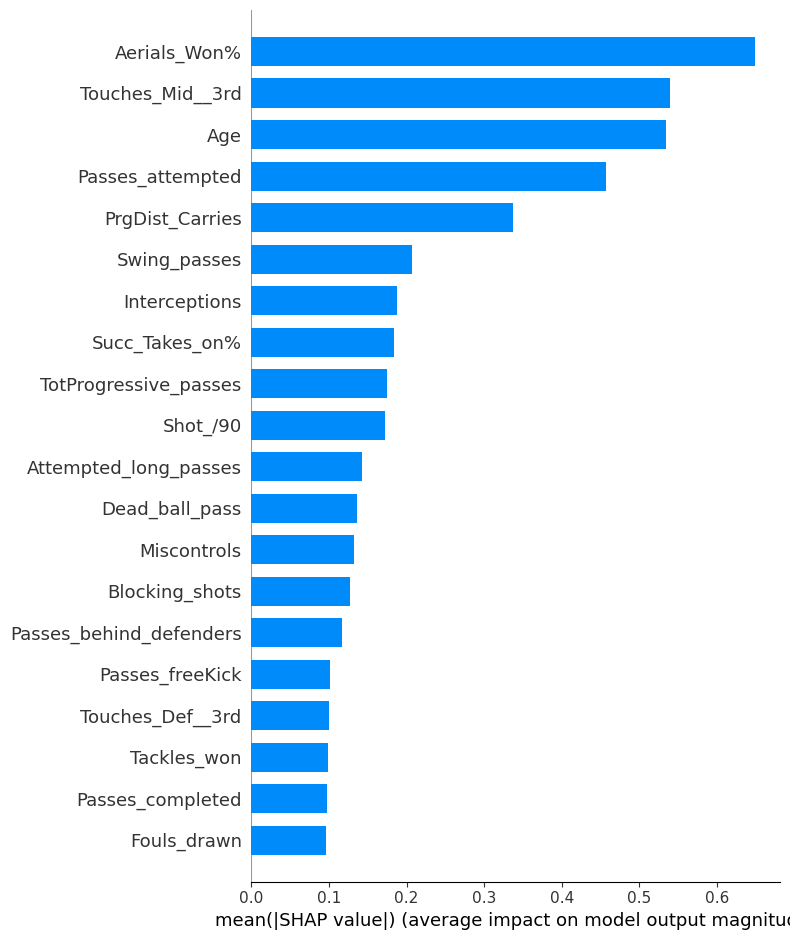

In [182]:
try:
    import shap
except ImportError:
    raise ImportError("shap is not installed. Run: pip install shap")

# Use a sample to keep it fast and stable
sample_n = min(400, len(X_central))
Xc_sample = X_central.sample(sample_n, random_state=42)

explainer_xgb = shap.TreeExplainer(best_xgb_central)
shap_values_xgb = explainer_xgb.shap_values(Xc_sample)

# Summary dot plot
shap.summary_plot(shap_values_xgb, Xc_sample, show=False)
plt.tight_layout()
plt.savefig("shap_summary_central_xgb.png", dpi=200)
plt.show()

# Summary bar plot
shap.summary_plot(shap_values_xgb, Xc_sample, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("shap_bar_central_xgb.png", dpi=200)
plt.show()


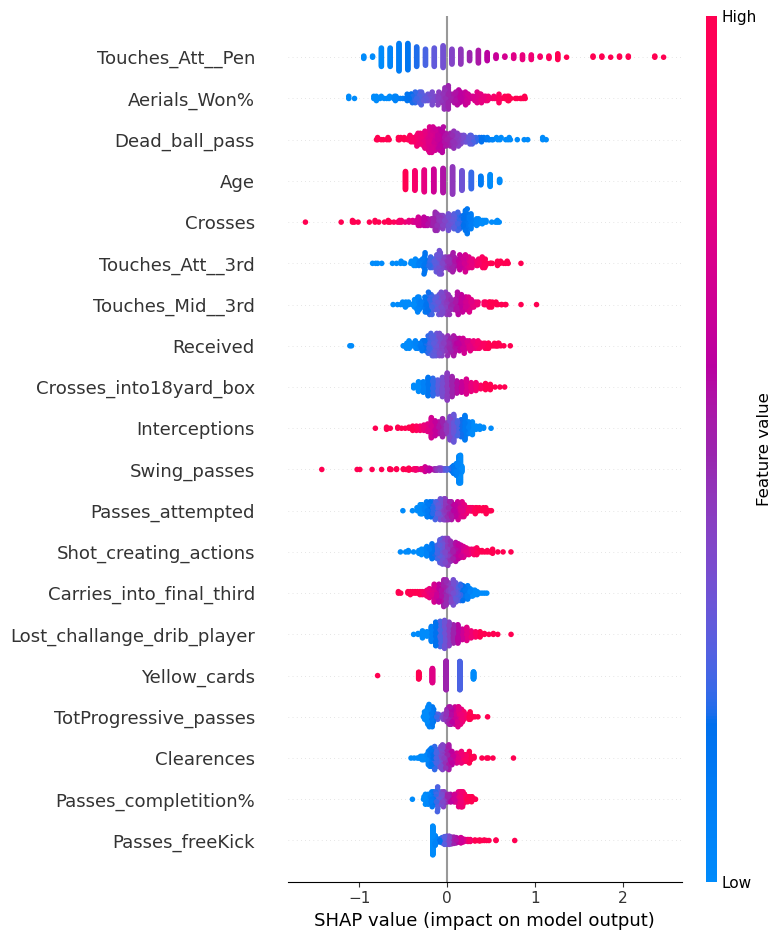

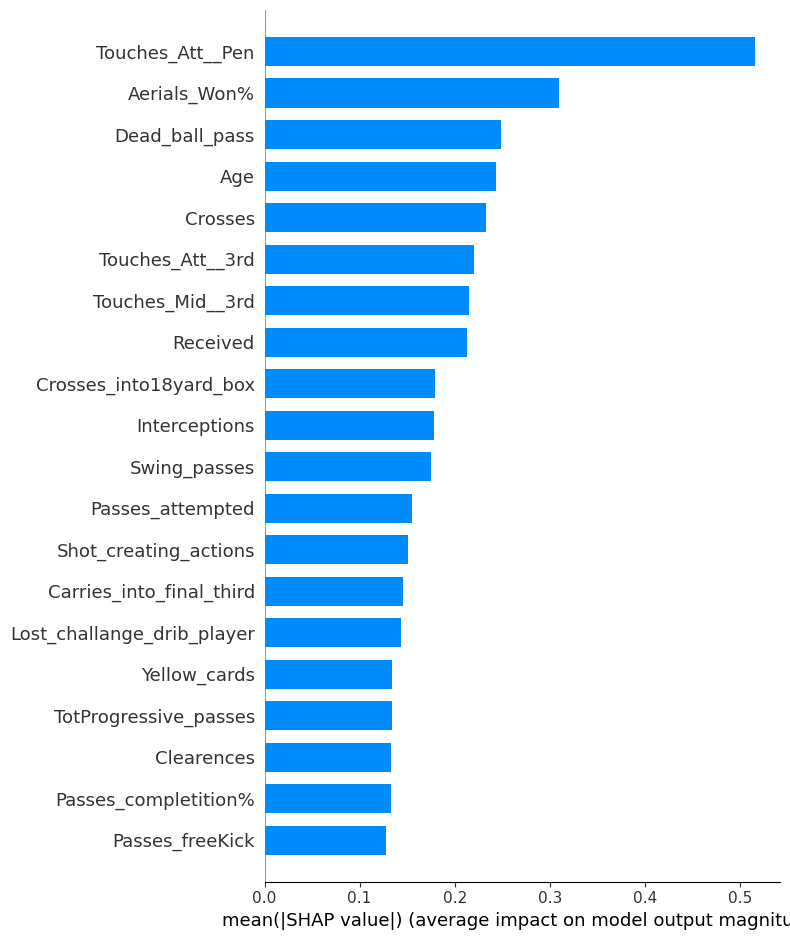

In [184]:
import shap

# Extract scaler + classifier from the pipeline
scaler_lat = best_log_lateral.named_steps["scaler"]
clf_lat = best_log_lateral.named_steps["clf"]

# Transform X into the same space the logistic model sees
Xl_scaled = scaler_lat.transform(X_lateral)

# SHAP LinearExplainer for logistic
explainer_log = shap.LinearExplainer(clf_lat, Xl_scaled, feature_names=X_lateral.columns)
shap_values_log = explainer_log.shap_values(Xl_scaled)

# Sample plot to keep it readable
sample_n = min(400, X_lateral.shape[0])
idx = np.random.RandomState(42).choice(X_lateral.shape[0], size=sample_n, replace=False)

Xl_scaled_sample = Xl_scaled[idx]
shap_values_log_sample = shap_values_log[idx]

# Summary plots
shap.summary_plot(shap_values_log_sample, Xl_scaled_sample, feature_names=X_lateral.columns, show=False)
plt.tight_layout()
plt.savefig("shap_summary_lateral_logistic.png", dpi=200)
plt.show()

shap.summary_plot(shap_values_log_sample, Xl_scaled_sample, feature_names=X_lateral.columns, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("shap_bar_lateral_logistic.png", dpi=200)
plt.show()
